<a href="https://colab.research.google.com/github/plaban1981/Dphi_hackathon/blob/main/Gender_Determination_DL_bootcamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

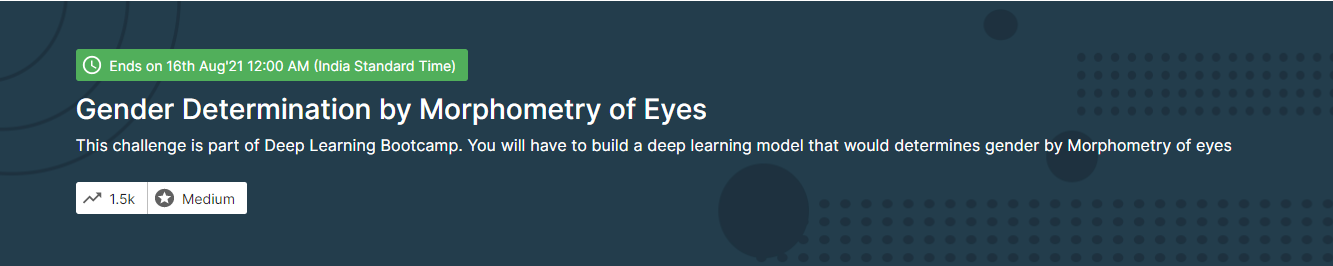

## Problem Statement
The anthropometric analysis of the human face is an essential study for performing craniofacial plastic and reconstructive surgeries. Facial anthropometrics are affected by various factors such as age, gender, ethnicity, socioeconomic status, environment, and region.  

 

Plastic surgeons who undertake the repair and reconstruction of facial deformities find the anatomical dimensions of the facial structures useful for their surgeries. These dimensions are a result of the Physical or Facial appearance of an individual. Along with factors like culture, personality, ethnic background, age; eye appearance and symmetry contributes majorly to the facial appearance or aesthetics. 

 

## Objective 
Build a model to scan the image of an eye of a patient and find if the gender of the patient is male or female.

## Evaluation 
Submissions are evaluated using **Accuracy Score** and the score displayed on the leaderboard is 100 * Accuracy Score.

## Problem Solution

## Download the images

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1f7uslI-ZHidriQFZR966_aILjlkgDN76',
dest_path='content/eye_gender_data.zip',
unzip=True)

Unzipping...Done.


## Loading Libraries

In [2]:
%%capture
!pip install ipyplot

In [3]:
import pandas as pd # Data analysis and manipultion tool
import numpy as np # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf # Deep Learning Tool
import os # OS module in Python provides a way of using operating system dependent functionality
import cv2 # Library for image processing
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set
from sklearn.metrics import f1_score, accuracy_score
import cv2
import ipyplot
from PIL  import Image
import seaborn as sns
import matplotlib.pyplot as plt



        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `base_64` param to `True`.
        


In [4]:
train = pd.read_csv("/content/content/eye_gender_data/Training_set.csv")
test = pd.read_csv("/content/content/eye_gender_data/Testing_set.csv")

In [5]:
train.head()

filename   label
0  Image_1.jpg    male
1  Image_2.jpg  female
2  Image_3.jpg  female
3  Image_4.jpg  female
4  Image_5.jpg    male

In [6]:
train_formated = train.copy()
train_formated['filename'] = "/content/content/eye_gender_data/train/" + train['filename']

In [7]:
train_formated.head()

filename   label
0  /content/content/eye_gender_data/train/Image_1...    male
1  /content/content/eye_gender_data/train/Image_2...  female
2  /content/content/eye_gender_data/train/Image_3...  female
3  /content/content/eye_gender_data/train/Image_4...  female
4  /content/content/eye_gender_data/train/Image_5...    male

## Prepare image and label lists

In [8]:
image_samples = train_formated['filename'].values.tolist()
image_labels = train_formated['label'].values.tolist()

In [9]:
import random
random.randint(1,100)

74

In [10]:
image_array = []
image_label_array = []
for i in range(16):
  index = random.randint(1,100)
  img = Image.open(image_samples[index])
  image_array.append(img)
  image_label_array.append(image_labels[index])

## Visualize Ranom Training Images

pro tip : https://www.linkedin.com/feed/update/urn:li:activity:6830366694209273856/


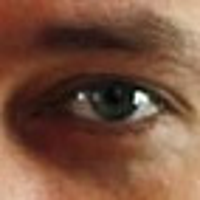
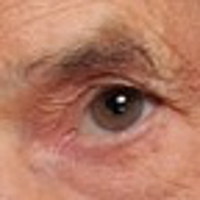
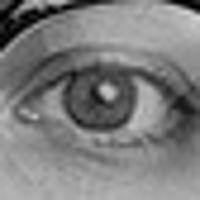
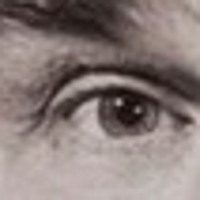
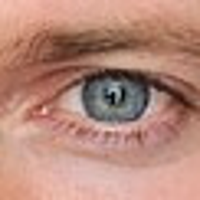
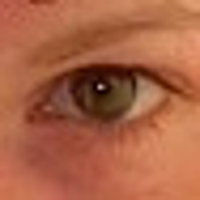
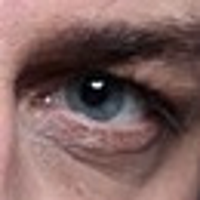
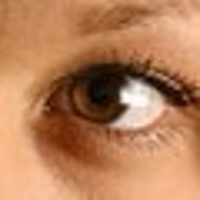
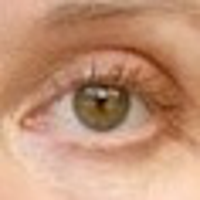
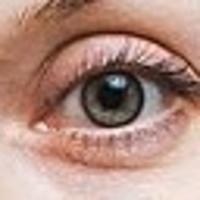
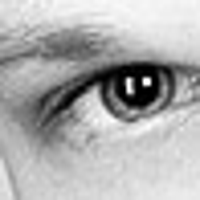
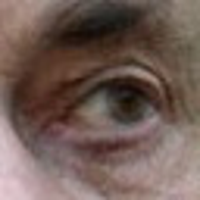
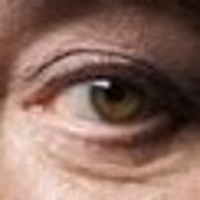
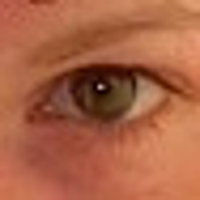
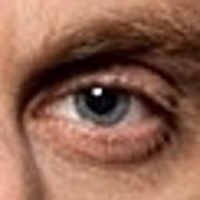
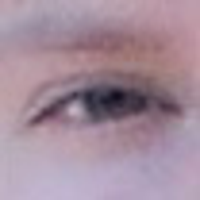


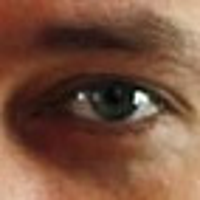
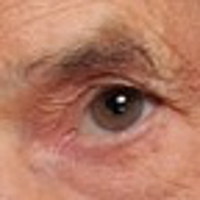
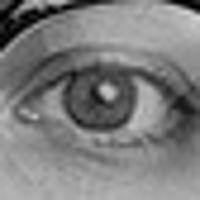
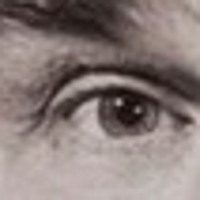
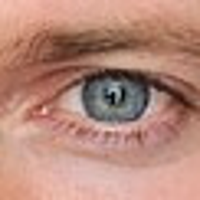
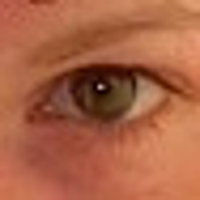
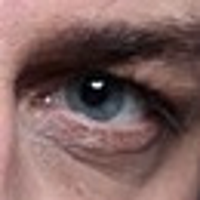
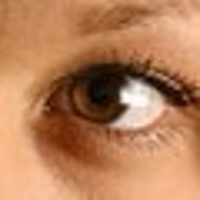
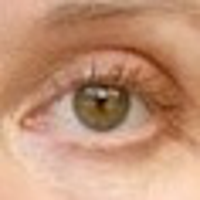
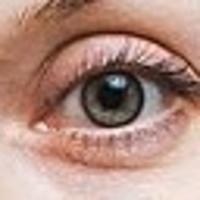
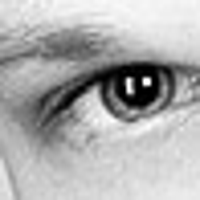
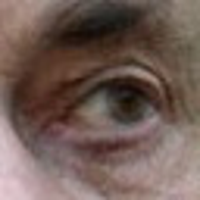
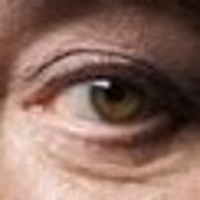
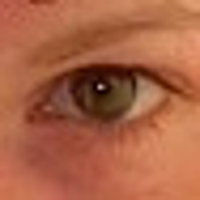
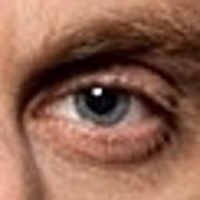
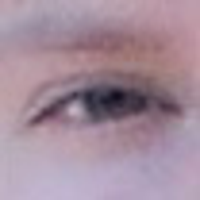

In [11]:
ipyplot.plot_images(image_array,image_label_array,img_width=200)

## Actual Size of the images 

In [11]:
img = cv2.imread(image_samples[0])
img.shape

(53, 53, 3)

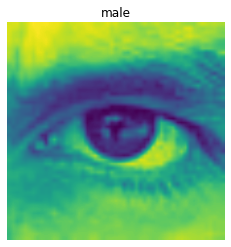

In [12]:
img = cv2.resize(img,(224,224))
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img)
plt.title(image_labels[0])
plt.axis('off')
plt.show()

## Applying Transfer Learning using Keras

In [13]:
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout,  Conv2D, Input, Lambda, Flatten, TimeDistributed, Activation, MaxPool2D
from tensorflow.keras.layers import Add, Reshape, MaxPooling2D, Concatenate, Embedding, RepeatVector, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import *
#
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
#
import os
import shutil
import cv2
import glob
from tqdm.notebook import tqdm
from tqdm import tqdm
from PIL import Image
#
import gc
#
import warnings
warnings.filterwarnings('ignore')

## Create an instance of the ImageDataGenerator class

In [14]:
batch_size=32
image_shape=(229,229,3)
class_mode='categorical'
dir_path = '/content/content/eye_gender_data/train'

## Train / Validation Data Generator

In [15]:
generator = ImageDataGenerator(rescale=1./255)

## Test Data Generator

In [16]:
test.head()

filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg

In [17]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="/content/content/eye_gender_data/test",
x_col="filename",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(229,229))
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 2305 validated image filenames.


## Define a function for getting model name in each of the k iterations

In [18]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

## Define a function to claibrate F1 Scores

In [19]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Create Model

In [20]:
def create_model():
  model = Sequential()

  conv_base = tf.keras.applications.DenseNet121(input_shape=(229,229,3), include_top=False, pooling='max',weights='imagenet')
  model.add(conv_base)
  model.add(BatchNormalization())
  model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dense(2, activation='softmax'))

  train_layers = [layer for layer in conv_base.layers[::-1][:5]]

  for layer in conv_base.layers:
    if layer in train_layers:
      layer.trainable = True
  return model

In [21]:
create_model().summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense (Dense)                (None, 2048)              2099200   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 9,153,090
Trainable params: 9,063,298
Non-trainable params: 89,792
_________________________________________________________________


In [22]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Model Traing Evaluation and Predictions

* Train the Model using StartifiedKFold Crossvalidation technique
* Getting the folds and creating the data generators
* Training the model on each Fold and evaluating on the validation fold
* Making the predictions on the test data badsed on the training for the fold
* Saving the predictions for each fold in a list
* Taking the average of all the five predictions made on the basis of each fold
 for the final predictions

Found 7376 validated image filenames belonging to 2 classes.
Found 1844 validated image filenames belonging to 2 classes.
Epoch 1/10
230/230 [==============================] - 61s 222ms/step - loss: 44.4586 - accuracy: 0.8132 - get_f1: 0.8126 - val_loss: 5.2642 - val_accuracy: 0.5581 - val_get_f1: 0.5581

Epoch 00001: val_loss improved from inf to 5.26417, saving model to /content/drive/MyDrive/dphi/Gender/saved_model/model_1.h5
Epoch 2/10
230/230 [==============================] - 49s 215ms/step - loss: 3.8147 - accuracy: 0.9059 - get_f1: 0.9060 - val_loss: 3.0115 - val_accuracy: 0.7599 - val_get_f1: 0.7599

Epoch 00002: val_loss improved from 5.26417 to 3.01150, saving model to /content/drive/MyDrive/dphi/Gender/saved_model/model_1.h5
Epoch 3/10
230/230 [==============================] - 49s 215ms/step - loss: 2.7332 - accuracy: 0.9202 - get_f1: 0.9202 - val_loss: 4.8143 - val_accuracy: 0.5784 - val_get_f1: 0.5784

Epoch 00003: val_loss did not improve from 3.01150
Epoch 4/10
230/230

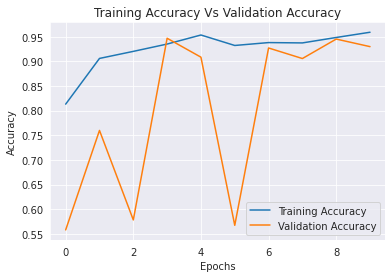

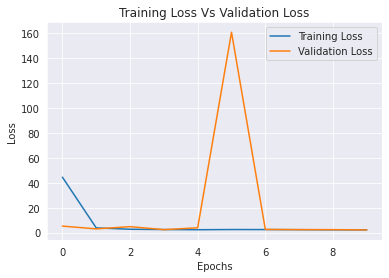

2305/2305 [==============================] - 42s 17ms/step
Found 7376 validated image filenames belonging to 2 classes.
Found 1844 validated image filenames belonging to 2 classes.
Epoch 1/10
230/230 [==============================] - 60s 222ms/step - loss: 43.8079 - accuracy: 0.8122 - get_f1: 0.8121 - val_loss: 3.3871 - val_accuracy: 0.7215 - val_get_f1: 0.7215

Epoch 00001: val_loss improved from inf to 3.38710, saving model to /content/drive/MyDrive/dphi/Gender/saved_model/model_2.h5
Epoch 2/10
230/230 [==============================] - 49s 215ms/step - loss: 2.7818 - accuracy: 0.9224 - get_f1: 0.9224 - val_loss: 2.6999 - val_accuracy: 0.9167 - val_get_f1: 0.9167

Epoch 00002: val_loss improved from 3.38710 to 2.69989, saving model to /content/drive/MyDrive/dphi/Gender/saved_model/model_2.h5
Epoch 3/10
230/230 [==============================] - 49s 215ms/step - loss: 2.6096 - accuracy: 0.9404 - get_f1: 0.9405 - val_loss: 2.5243 - val_accuracy: 0.9370 - val_get_f1: 0.9370

Epoch 0000

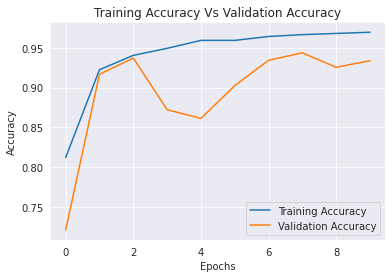

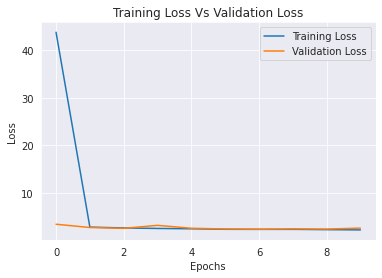

2305/2305 [==============================] - 42s 18ms/step
Found 7376 validated image filenames belonging to 2 classes.
Found 1844 validated image filenames belonging to 2 classes.
Epoch 1/10
230/230 [==============================] - 61s 223ms/step - loss: 44.5077 - accuracy: 0.8027 - get_f1: 0.8029 - val_loss: 3.6885 - val_accuracy: 0.8969 - val_get_f1: 0.8969

Epoch 00001: val_loss improved from inf to 3.68851, saving model to /content/drive/MyDrive/dphi/Gender/saved_model/model_3.h5
Epoch 2/10
230/230 [==============================] - 49s 215ms/step - loss: 2.8985 - accuracy: 0.9114 - get_f1: 0.9111 - val_loss: 2.6599 - val_accuracy: 0.9370 - val_get_f1: 0.9370

Epoch 00002: val_loss improved from 3.68851 to 2.65987, saving model to /content/drive/MyDrive/dphi/Gender/saved_model/model_3.h5
Epoch 3/10
230/230 [==============================] - 49s 215ms/step - loss: 2.5070 - accuracy: 0.9427 - get_f1: 0.9427 - val_loss: 2.5017 - val_accuracy: 0.9375 - val_get_f1: 0.9375

Epoch 0000

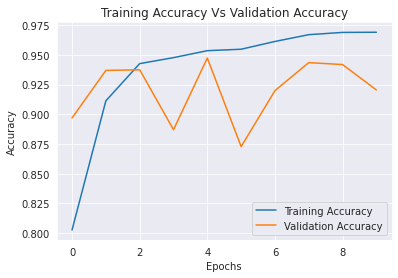

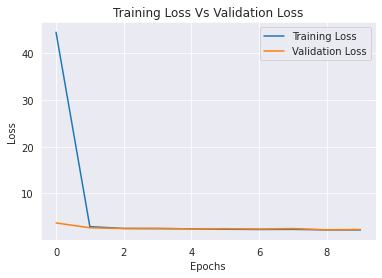

2305/2305 [==============================] - 41s 17ms/step
Found 7376 validated image filenames belonging to 2 classes.
Found 1844 validated image filenames belonging to 2 classes.
Epoch 1/10
230/230 [==============================] - 60s 222ms/step - loss: 44.6757 - accuracy: 0.7987 - get_f1: 0.7982 - val_loss: 7.2317 - val_accuracy: 0.6009 - val_get_f1: 0.6009

Epoch 00001: val_loss improved from inf to 7.23175, saving model to /content/drive/MyDrive/dphi/Gender/saved_model/model_4.h5
Epoch 2/10
230/230 [==============================] - 49s 214ms/step - loss: 4.0604 - accuracy: 0.8862 - get_f1: 0.8860 - val_loss: 4.6611 - val_accuracy: 0.8640 - val_get_f1: 0.8640

Epoch 00002: val_loss improved from 7.23175 to 4.66113, saving model to /content/drive/MyDrive/dphi/Gender/saved_model/model_4.h5
Epoch 3/10
230/230 [==============================] - 49s 214ms/step - loss: 3.1165 - accuracy: 0.9146 - get_f1: 0.9144 - val_loss: 2.6906 - val_accuracy: 0.6820 - val_get_f1: 0.6820

Epoch 0000

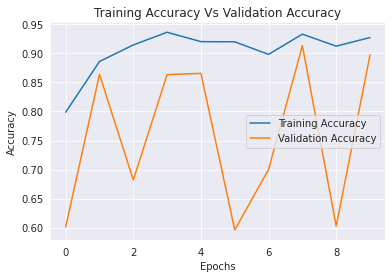

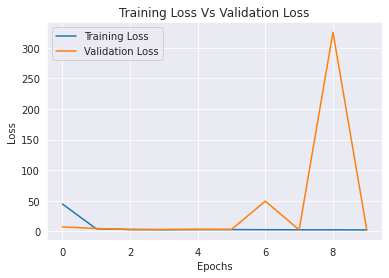

2305/2305 [==============================] - 41s 17ms/step
Found 7376 validated image filenames belonging to 2 classes.
Found 1844 validated image filenames belonging to 2 classes.
Epoch 1/10
230/230 [==============================] - 61s 223ms/step - loss: 44.5521 - accuracy: 0.8053 - get_f1: 0.8050 - val_loss: 3.6575 - val_accuracy: 0.7478 - val_get_f1: 0.7478

Epoch 00001: val_loss improved from inf to 3.65749, saving model to /content/drive/MyDrive/dphi/Gender/saved_model/model_5.h5
Epoch 2/10
230/230 [==============================] - 49s 215ms/step - loss: 3.0476 - accuracy: 0.9193 - get_f1: 0.9192 - val_loss: 3.0203 - val_accuracy: 0.9172 - val_get_f1: 0.9172

Epoch 00002: val_loss improved from 3.65749 to 3.02033, saving model to /content/drive/MyDrive/dphi/Gender/saved_model/model_5.h5
Epoch 3/10
230/230 [==============================] - 50s 215ms/step - loss: 2.5986 - accuracy: 0.9393 - get_f1: 0.9394 - val_loss: 2.6717 - val_accuracy: 0.8536 - val_get_f1: 0.8536

Epoch 0000

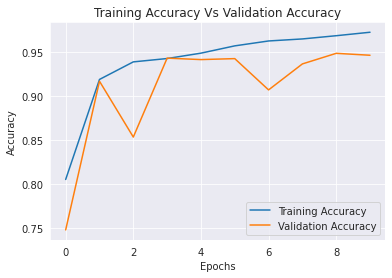

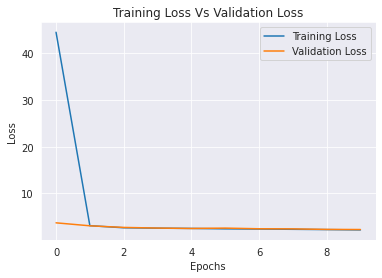

2305/2305 [==============================] - 43s 18ms/step


In [25]:
from keras.models import load_model
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []
all_preds = []
dropout=.3
lr=.001
num_epochs = 15
save_dir = '/content/drive/MyDrive/dphi/Gender/saved_model/'
fold_var = 1
n_class = 2
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
#
for train_index, val_index in skf.split(train,train.label):
	training_data = train.iloc[train_index]
	validation_data = train.iloc[val_index]
	
	train_data_generator = generator.flow_from_dataframe(training_data, 
                                                      directory = dir_path,
			 	 	 	                                          x_col = "filename", 
                                                      y_col = "label",
						                                          class_mode = class_mode, 
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      target_size=(229,229))
	valid_data_generator  = generator.flow_from_dataframe(validation_data, 
                                                       directory = dir_path,
							                                          x_col = "filename", 
                                                        y_col = "label",
						                                            class_mode = class_mode, 
                                                        batch_size = 32,
                                                        seed = 42,
                                                        shuffle = True,
                                                        target_size=(229,229))
	
	# CREATE NEW MODEL
	model = create_model()
	# COMPILE NEW MODEL
	model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.001,decay=0.0001),
                  metrics=["accuracy",get_f1],
                  loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1))
	# CREATE CALLBACKS
	
	my_callbacks = [
               tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), monitor = 'val_loss',verbose = 1,save_weights_only=False, save_best_only = True),
              EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),
              ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min',min_delta=1e-4)
	]

	# There can be other callbacks, but just showing one because it involves the model name
	# This saves the best model
	# FIT THE MODEL
	STEP_SIZE_TRAIN = train_data_generator.n//train_data_generator.batch_size
	STEP_SIZE_VALID = valid_data_generator.n//valid_data_generator.batch_size
	history = model.fit(
        train_data_generator,
        steps_per_epoch= STEP_SIZE_TRAIN,
        epochs=10,
        validation_data=valid_data_generator,
        validation_steps= STEP_SIZE_VALID,
        callbacks=[my_callbacks], 
        )
	#PLOT HISTORY
	#		:
	plt.plot(history.history['accuracy'],label='Training Accuracy')
	plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
	plt.xlabel('Epochs')
	plt.ylabel('Accuracy')
	plt.title('Training Accuracy Vs Validation Accuracy')
	plt.legend()
	plt.show()
  #
	plt.plot(history.history['loss'],label='Training Loss')
	plt.plot(history.history['val_loss'],label='Validation Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.title('Training Loss Vs Validation Loss')
	plt.legend()
	plt.show()
	#		:
	
	# LOAD BEST MODEL to evaluate the performance of the model
	model.load_weights("/content/drive/MyDrive/dphi/Gender/saved_model/model_"+str(fold_var)+".h5")
	results = model.evaluate(valid_data_generator)
	results = dict(zip(model.metrics_names,results))
	
	VALIDATION_ACCURACY.append(results['accuracy'])
	VALIDAITON_LOSS.append(results['loss'])
	preds = model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)
	all_preds.append(preds)
	#
	tf.keras.backend.clear_session()
	gc.collect()
	fold_var += 1


## Predictions 

In [23]:
# CREATE NEW MODEL
model = create_model()
# COMPILE NEW MODEL
model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.001,decay=0.0001),
                  metrics=["accuracy",get_f1],
                  loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1))


In [25]:
all_preds = []
for fold_var in range(1,6):
  # LOAD BEST MODEL to evaluate the performance of the model
	model.load_weights("/content/drive/MyDrive/dphi/Gender/saved_model/model_"+str(fold_var)+".h5")
	preds = model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)
	all_preds.append(preds)


2305/2305 [==============================] - 39s 17ms/step


## Final Predictions

In [26]:
final_pred = (all_preds[0] + all_preds[1] + all_preds[2] + all_preds[3] + all_preds[4])/5
predictions = np.argmax(final_pred,axis=1)

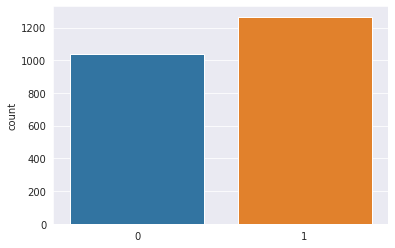

In [28]:
import seaborn as sns
sns.countplot(predictions)

In [29]:
sub = pd.read_csv("/content/content/eye_gender_data/sample_submission.csv")

In [30]:
sub.head()

label
0  male
1  male
2  male
3  male
4  male

## Prediction Mapper

In [31]:
#prediction_mapper = { v: k for k,v in valid_data_generator.class_indices.items()}
prediction_mapper = {0:'female',1: 'male'}
prediction_mapper

{0: 'female', 1: 'male'}

In [32]:
test['label'] = predictions
test['label'] = test['label'].map(prediction_mapper)
test.head()

filename label
0  Image_1.jpg  male
1  Image_2.jpg  male
2  Image_3.jpg  male
3  Image_4.jpg  male
4  Image_5.jpg  male

# Submitting the predictions mdade on the test data

In [33]:
test['label'].to_csv('gender_classification_densenet201.csv',index=False)

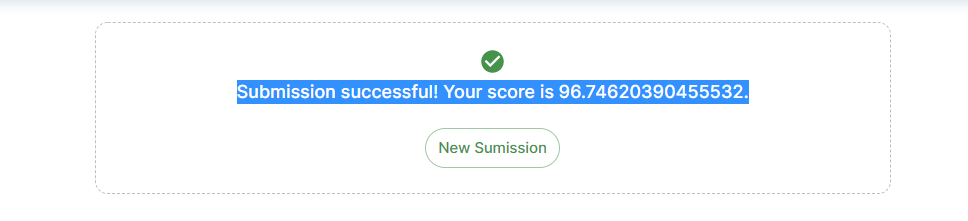

## Visualize predictions

In [34]:
image_samples = test['filename'].values.tolist()
image_labels = test['label'].values.tolist()

In [35]:
image_array = []
image_label_array = []
for i in range(16):
  index = random.randint(1,100)
  images = os.path.join("/content/content/eye_gender_data/test",image_samples[index])
  img = Image.open(images)
  image_array.append(img)
  image_label_array.append(image_labels[index])


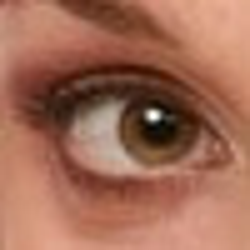
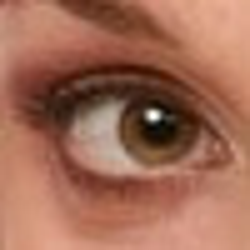
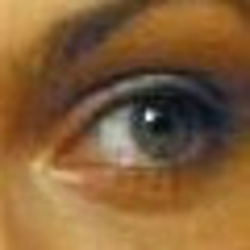
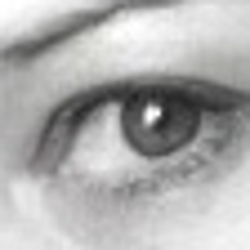
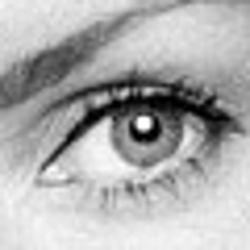
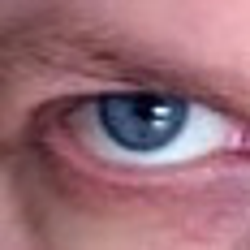
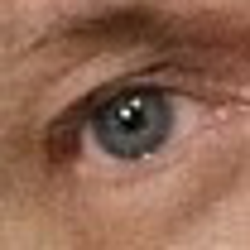
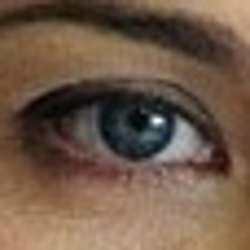
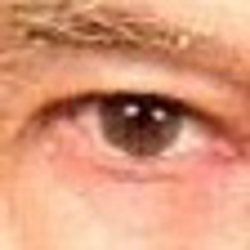
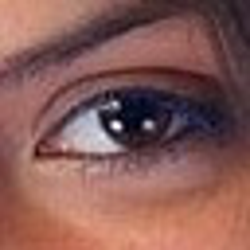
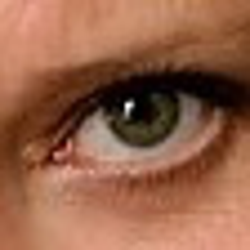
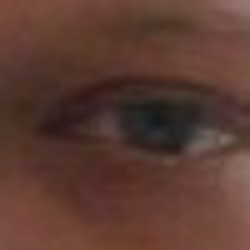
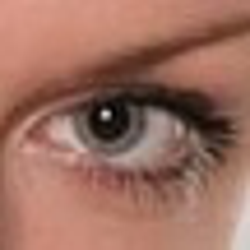
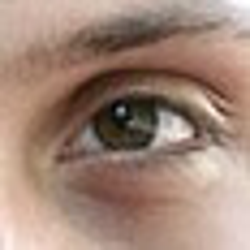
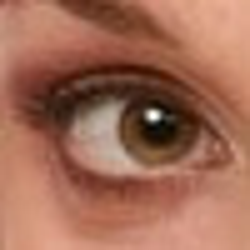
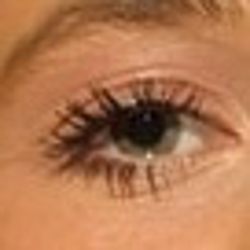


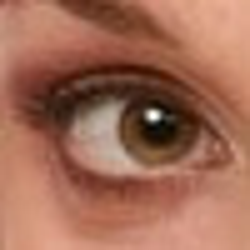
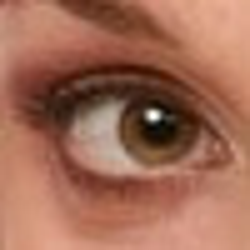
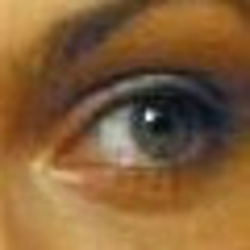
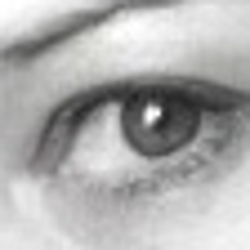
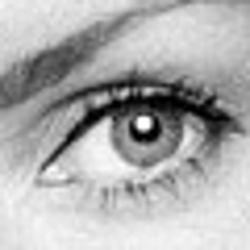
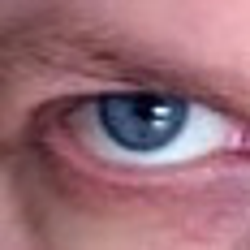
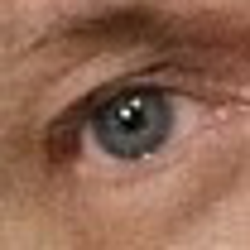
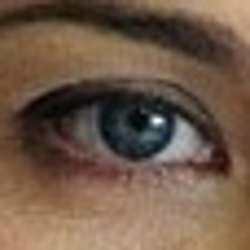
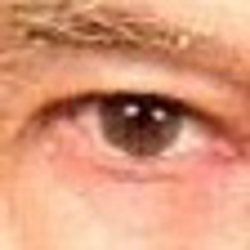
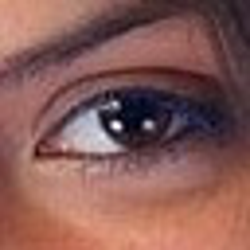
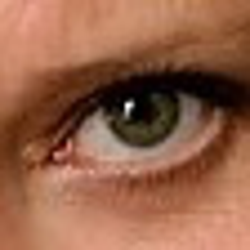
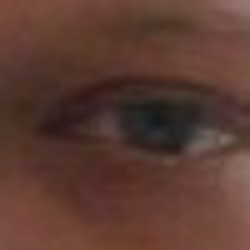
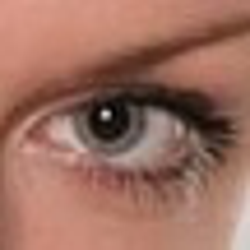
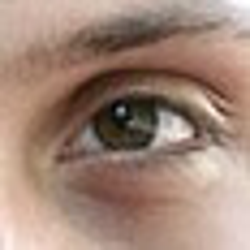
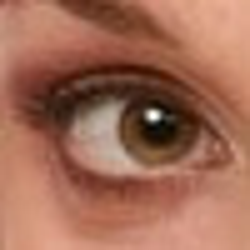
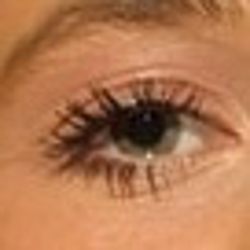

In [36]:
ipyplot.plot_images(image_array,image_label_array,img_width=250)

## Hackathon Ranking

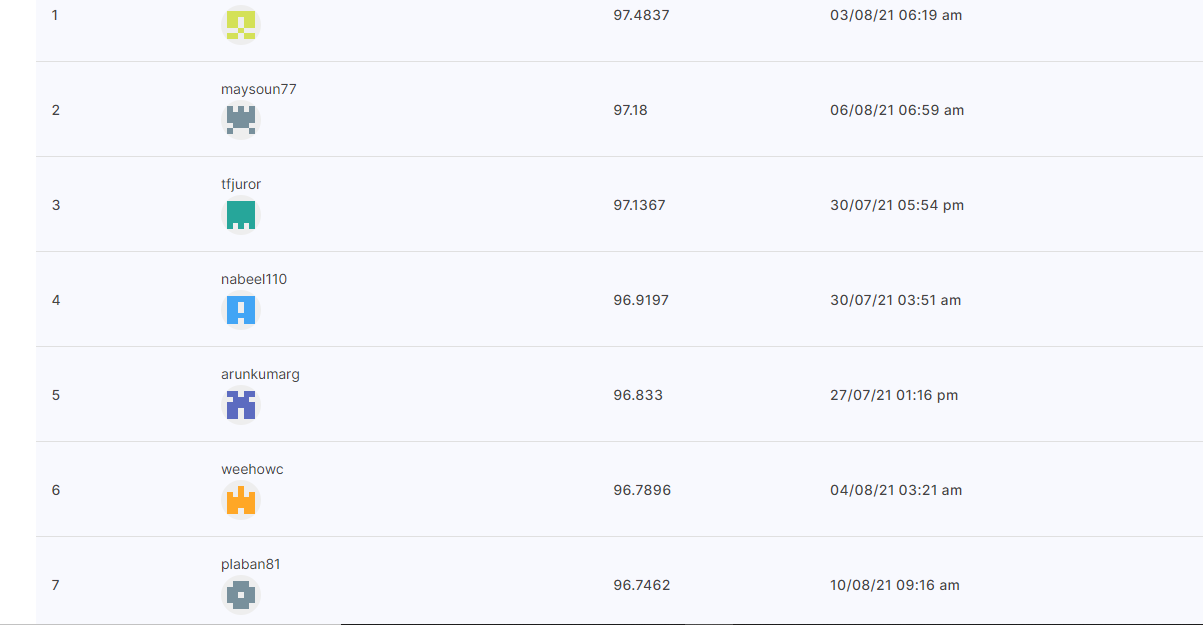